In [44]:
# Install required packages
!pip install langchain-google-genai langgraph python-dotenv langchain-core -q

In [ ]:
# Set your Google API Key directly
import os
os.environ['GOOGLE_API_KEY'] = ""

In [46]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

# IELTS Writing Task 2 Essay Evaluation Workflow

This notebook evaluates IELTS Writing Task 2 essays using Google's Gemini 2.5 Flash model with LangGraph parallel workflows.

## Setup Instructions

**Required: Google Gemini API Key**

To use this notebook, you need a Google Gemini API key. 

### How to get your Gemini API key:
1. Visit [Google AI Studio](https://aistudio.google.com/app/apikey)
2. Sign in with your Google account
3. Click "Create API Key"
4. Copy your API key

### Option 1: Set API key in notebook (Quick Test)
Run the cell below and paste your API key when prompted (for quick testing only):

```python
import os
from getpass import getpass
os.environ['GOOGLE_API_KEY'] = getpass('Enter your Google API Key: ')
```

### Option 2: Use .env file (Recommended for production)
Create a `.env` file in the project root directory with:
```
GOOGLE_API_KEY=your_gemini_api_key_here
```

**Important:** Never commit your `.env` file or API key to version control. Add `.env` to `.gitignore`.

In [47]:
# Load environment variables (including GOOGLE_API_KEY from .env file)
load_dotenv()

False

In [48]:
# Initialize Gemini 2.5 Flash model
# The API key is automatically loaded from GOOGLE_API_KEY environment variable
model = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [49]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description='Detailed feedback for the essay based on IELTS criteria')
    score: float = Field(description='Band score from 0 to 9 (can be 0.5 increments like 6.5, 7.0)', ge=0, le=9)

In [50]:
structured_model = model.with_structured_output(EvaluationSchema)

In [ ]:
# IELTS Writing Task 2 Sample Essay (Band 7-8 level)
essay = """Some people believe that technology has made our lives more complicated, while others argue that it has simplified our daily routines. Discuss both views and give your own opinion.

In the contemporary era, technology has become an integral part of human existence, fundamentally transforming how we live, work, and communicate. While some individuals contend that technological advancements have introduced unnecessary complexity into our lives, others maintain that these innovations have streamlined numerous aspects of daily living. This essay will examine both perspectives before presenting my own viewpoint.

On the one hand, there are valid arguments supporting the notion that technology has complicated modern life. The constant connectivity enabled by smartphones and the internet has blurred the boundaries between work and personal time, leading to increased stress and burnout. Moreover, the rapid pace of technological change requires continuous learning and adaptation, which can be overwhelming for many individuals, particularly older generations who did not grow up with digital devices. Additionally, cybersecurity concerns and the need to manage multiple passwords and accounts have added new layers of complexity to everyday activities.

On the other hand, proponents of technology argue that it has significantly simplified various aspects of life. Online banking and digital payment systems have eliminated the need for physical visits to banks, saving considerable time and effort. Similarly, e-commerce platforms allow consumers to purchase virtually anything from the comfort of their homes, while GPS navigation has made traveling to unfamiliar locations remarkably straightforward. Furthermore, communication with friends and family across geographical boundaries has become instantaneous through video calling and messaging applications.

In my opinion, while technology has introduced certain challenges, its overall impact on simplifying life outweighs the complications it has created. The key lies in developing digital literacy and establishing healthy boundaries with technology use. When used mindfully, technological tools can enhance productivity, foster connections, and provide access to information and services that were previously inaccessible.

In conclusion, although technology has brought some complexity to modern life, its benefits in terms of convenience, efficiency, and connectivity are undeniable. Society should focus on adapting to technological changes while maintaining a balanced approach to its usage."""

In [ ]:
prompt = f'Evaluate the Task Response (how well the essay addresses the task) of the following IELTS Writing Task 2 essay and provide feedback and assign a band score from 0 to 9 \n {essay}'
structured_model.invoke(prompt).feedback

In [ ]:
# IELTS Writing Task 2 has 4 marking criteria:
# 1. Task Response (TR) - How well the essay addresses the task
# 2. Coherence and Cohesion (CC) - Organization and logical flow
# 3. Lexical Resource (LR) - Vocabulary range and accuracy
# 4. Grammatical Range and Accuracy (GRA) - Grammar variety and correctness

class IELTSState(TypedDict):

    essay: str
    task_response_feedback: str
    coherence_cohesion_feedback: str
    lexical_resource_feedback: str
    grammatical_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[float], operator.add]
    avg_score: float

In [ ]:
def evaluate_task_response(state: IELTSState):
    """Evaluate Task Response (TR) - How well the essay addresses all parts of the task"""
    prompt = f'''Evaluate the TASK RESPONSE of the following IELTS Writing Task 2 essay.
    
Consider:
- Does the essay fully address all parts of the task?
- Is there a clear position throughout the response?
- Are main ideas relevant, extended and well-supported?
- Is the response at least 250 words?

Provide detailed feedback and assign a band score from 0 to 9.

Essay:
{state["essay"]}'''
    output = structured_model.invoke(prompt)

    return {'task_response_feedback': output.feedback, 'individual_scores': [output.score]}

In [ ]:
def evaluate_coherence_cohesion(state: IELTSState):
    """Evaluate Coherence and Cohesion (CC) - Organization and logical flow"""
    prompt = f'''Evaluate the COHERENCE AND COHESION of the following IELTS Writing Task 2 essay.
    
Consider:
- Is information and ideas logically organized?
- Is there clear progression throughout the essay?
- Are paragraphing techniques used appropriately?
- Are cohesive devices (linking words, referencing) used effectively?

Provide detailed feedback and assign a band score from 0 to 9.

Essay:
{state["essay"]}'''
    output = structured_model.invoke(prompt)

    return {'coherence_cohesion_feedback': output.feedback, 'individual_scores': [output.score]}

In [ ]:
def evaluate_lexical_resource(state: IELTSState):
    """Evaluate Lexical Resource (LR) - Vocabulary range and accuracy"""
    prompt = f'''Evaluate the LEXICAL RESOURCE of the following IELTS Writing Task 2 essay.
    
Consider:
- Is there a wide range of vocabulary?
- Are less common lexical items used with awareness of style and collocation?
- Are there any spelling or word formation errors?
- Is vocabulary used precisely and appropriately?

Provide detailed feedback and assign a band score from 0 to 9.

Essay:
{state["essay"]}'''
    output = structured_model.invoke(prompt)

    return {'lexical_resource_feedback': output.feedback, 'individual_scores': [output.score]}

In [ ]:
def evaluate_grammatical_range(state: IELTSState):
    """Evaluate Grammatical Range and Accuracy (GRA) - Grammar variety and correctness"""
    prompt = f'''Evaluate the GRAMMATICAL RANGE AND ACCURACY of the following IELTS Writing Task 2 essay.
    
Consider:
- Is there a wide range of sentence structures?
- Are complex sentences used accurately?
- Is grammar and punctuation used accurately?
- Are there any grammatical errors that impede communication?

Provide detailed feedback and assign a band score from 0 to 9.

Essay:
{state["essay"]}'''
    output = structured_model.invoke(prompt)

    return {'grammatical_feedback': output.feedback, 'individual_scores': [output.score]}

In [ ]:
def final_evaluation(state: IELTSState):
    """Generate overall IELTS band score and summarized feedback"""
    # summary feedback
    prompt = f'''Based on the following IELTS Writing Task 2 evaluation feedbacks, create a comprehensive summary with:
1. Key strengths of the essay
2. Areas for improvement
3. Specific tips to improve the band score

Task Response feedback: {state["task_response_feedback"]}
Coherence and Cohesion feedback: {state["coherence_cohesion_feedback"]}
Lexical Resource feedback: {state["lexical_resource_feedback"]}
Grammatical Range and Accuracy feedback: {state["grammatical_feedback"]}'''
    
    overall_feedback = model.invoke(prompt).content

    # Calculate average band score (IELTS uses average of 4 criteria, rounded to nearest 0.5)
    avg_score = sum(state['individual_scores']) / len(state['individual_scores'])
    # Round to nearest 0.5
    avg_score = round(avg_score * 2) / 2

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [ ]:
graph = StateGraph(IELTSState)

# Add nodes for each IELTS criterion
graph.add_node('evaluate_task_response', evaluate_task_response)
graph.add_node('evaluate_coherence_cohesion', evaluate_coherence_cohesion)
graph.add_node('evaluate_lexical_resource', evaluate_lexical_resource)
graph.add_node('evaluate_grammatical_range', evaluate_grammatical_range)
graph.add_node('final_evaluation', final_evaluation)

# Parallel edges from START to all 4 evaluation nodes
graph.add_edge(START, 'evaluate_task_response')
graph.add_edge(START, 'evaluate_coherence_cohesion')
graph.add_edge(START, 'evaluate_lexical_resource')
graph.add_edge(START, 'evaluate_grammatical_range')

# All evaluation nodes connect to final evaluation
graph.add_edge('evaluate_task_response', 'final_evaluation')
graph.add_edge('evaluate_coherence_cohesion', 'final_evaluation')
graph.add_edge('evaluate_lexical_resource', 'final_evaluation')
graph.add_edge('evaluate_grammatical_range', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()

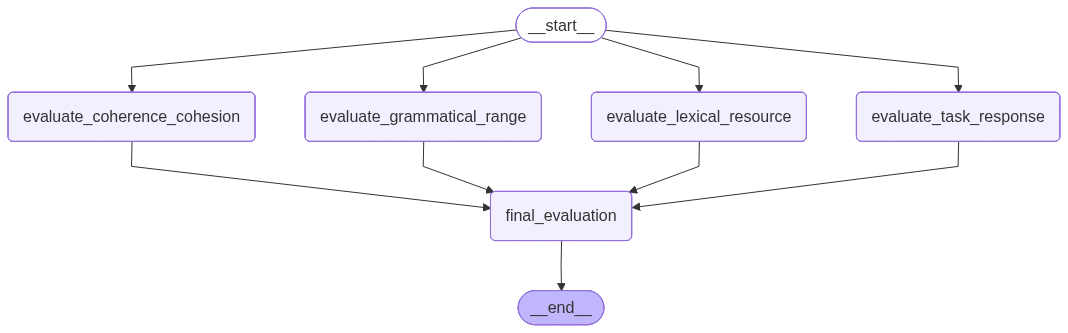

In [ ]:
workflow

In [ ]:
# Test with a lower band essay (Band 5-6 level)
essay2 = """Some people believe that technology has made our lives more complicated, while others argue that it has simplified our daily routines. Discuss both views and give your own opinion.

Nowadays technology is very important in our life. Some people think technology make life hard and some think it make life easy. I will discuss both side and give my opinion.

First, technology make life complicated because of many reason. People always look at phone and computer. They forget to talk to family and friend. Also many old people dont know how use new technology. They feel stress and confused. Also internet have many dangerous like hacking and virus. People worry about their information being stolen.

On other hand, technology also make life simple. We can do shopping online without go to market. We can talk to friend in other country using video call. Also we can use GPS when we dont know the way. Bank work also easy now because of mobile banking. We dont need go to bank and wait in long line.

In my opinion I think technology is good but we should use carefully. We should not use phone too much and we should learn how to protect ourself from bad people on internet. Parents should teach children about good use of technology.

In conclusion, technology have good point and bad point. If we use wisely technology can help us lot. But if we use too much it can cause problem. So we need balance."""

## Test the Workflow

Now let's test the workflow with a sample essay. The workflow will evaluate the essay on all 4 IELTS criteria in parallel.

**Note:** If you encounter a rate limit error (429 RESOURCE_EXHAUSTED), wait for 1-2 minutes before running the cell again. The free tier of Gemini API has limited requests per minute.

In [ ]:
initial_state = {
    'essay': essay2
}

result = workflow.invoke(initial_state)
result

In [ ]:
# Display formatted results
print("="*60)
print("IELTS WRITING TASK 2 EVALUATION REPORT")
print("="*60)
print(f"\n OVERALL BAND SCORE: {result['avg_score']}")
print("\n" + "-"*60)
print("\n INDIVIDUAL SCORES:")
print(f"   Task Response: {result['individual_scores'][0]}")
print(f"   Coherence & Cohesion: {result['individual_scores'][1]}")
print(f"   Lexical Resource: {result['individual_scores'][2]}")
print(f"   Grammatical Range & Accuracy: {result['individual_scores'][3]}")
print("\n" + "-"*60)
print("\n OVERALL FEEDBACK:")
print(result['overall_feedback'])